In [1]:
import json
import spacy
import re

from tqdm import tqdm_notebook
import pandas as pd 

from collections import Counter

import matplotlib.pyplot as plt

from numpy.random import rand

from random import sample

import seaborn as sns

In [2]:
nlp = spacy.load('en')

f = open('./wrond_id_BERT_squad2.0_wa.txt','rt')
wrong_bert_wa = f.readlines()
f.close()

f = open('./wrond_id_BERT_squad2.0_fp.txt','rt')
wrong_bert_fp = f.readlines()
f.close()

f = open('./wrond_id_BERT_squad2.0_fn.txt','rt')
wrong_bert_fn = f.readlines()
f.close()

def removen(file):
    return [line.rstrip('\n') for line in file]

wrong_bert_wa = removen(wrong_bert_wa)
wrong_bert_fp = removen(wrong_bert_fp)
wrong_bert_fn = removen(wrong_bert_fn)

wrong_bert_wa = set(wrong_bert_wa)
wrong_bert_fp = set(wrong_bert_fp)
wrong_bert_fn = set(wrong_bert_fn)

In [3]:
candidate = ['when', 'how', 'where', 'which', 'what', 'who', 'how many', 'whose', 'whom', 'why']
how_words = ['many','tall','much','tall','old', 'often', 'deep', 'high', 'long', 'far', 'wide']
changelist = ['(what?)', '(what)', '(which?)', '(Which?)', '(which)', '(Which)']

## WH type wrong probability

def _wh_helper(sentence):
    doc = nlp(sentence)
    
    if sentence.startswith('name'): return 'name'
    
    if 'how' in sentence.split():
        list_of_words = sentence.split()
        if list_of_words.index('how') != len(list_of_words)-1: 
            next_word = list_of_words[list_of_words.index('how') + 1]
            if next_word in how_words:
                return 'how many'
        
    
    for w in reversed(doc):
        if w.pos_ == 'NN': continue
        else:
            for can in candidate:
                if can in w.text.split():
                    return can
            break
    
    whs = []

    for idx, token in enumerate(doc):
        for can in candidate:
            if can in token.text.split():
                return can
            
    if doc[-1].lemma_ == 'be' or doc[-1].pos_ == 'ADP':
        return 'implicit_what'
    
    if 'name' in sentence.lower():
        return 'name'
    
    return 'none'

def findWHword(sentence):
    
    sentence = sentence.lower()
    osentence = sentence
    
    x = re.findall("\(wha.*?\)", sentence)

    if x != []:
        return 'cloze'
    
    if sentence.count('\"') > 0:
        sentence = changepartsent(re.findall(r'"([^"]*)"', sentence), 'QUOTES', sentence)
    if (sentence.count('\'')-sentence.count('\'s')) % 2 == 0 and sentence.count('\'')-sentence.count('\'s') > 0:
        sentence = changepartsent(re.findall(r"'(.*?)'", sentence), 'QUOTES', sentence)
        
    sentence = re.sub('\,.+?\,', '', sentence)
        
    wh = _wh_helper(sentence)
    if wh == 'none':
        wh = _wh_helper(osentence)
    
    return wh

In [4]:
def changepartsent(word, reword, sentence):
    '''
    Change the part of sentence from word to reword
    @param word
         	@word that targeted to change
    @param reword
         	@word in sentence is replaced to @reword
    @param sentence
         	sentence string
    @return the changed string
    '''
    
    if type(word) is list:
        for w in word:
            sentence = sentence.replace(w,reword)

    else:
        sentence = sentence.replace(word,reword)
        sentence = sentence.replace(word[0].upper()+word[1:],reword)
    
    return sentence

In [5]:
import collections

In [6]:
answer_type_map = {'when':['TIME','DATE'],
                   'how': [], 
                   'where' : ['FAC', 'ORG', 'GPE', 'LOC'], 
                   'which': [], 
                   'what': [],
                   'who' : ['PERSON', 'NORP'], 
                   'how many': ['QUANTITY', 'CARDINAL', 'MONEY', 'PERCENT'], 
                   'why': [],
                   'none': [],
                   'implicit_what': [],
                   'name': [],
                   'cloze': []
                  }

In [7]:
f = open('./squad/dev-v2.0.json','rb')
data = json.load(f)

data = data['data']

all_qid = []

possible_answers_hard = collections.Counter()
possible_answers_soft = collections.Counter()
for document in tqdm_notebook(data):
    for paragraph in document['paragraphs']:
        document = paragraph['context']
        doc = nlp(document)
        
        ners = [ent.label_ for ent in doc.ents]
        nercnt = collections.Counter(ners)
        
        for qas in paragraph['qas']:
            ans_type = []
            for ent in doc.ents:
                for answer in qas['answers']:
                    if ent.text.lower() in answer['text'].lower() or answer['text'].lower() in ent.text.lower():
                        ans_type.append(ent.label_)
                        break
                if len(ans_type) > 0: break
                    
            wh = findWHword(qas['question'])
            if wh == 'whose' or wh == 'whom': wh = 'who'
            
            ## hard option
            if len(ans_type) > 0:
                possible_answers_hard[qas['id']] = nercnt[ans_type[0]]
                
            ## soft option
            ans_type.extend(answer_type_map[wh])
            for at in set(ans_type):
                possible_answers_soft[qas['id']] += nercnt[at]

## WH type count same answer type

In [31]:
test_candy = ['who','where','when','how many', 'what']

In [32]:
hard_cnt_who = []
soft_cnt_who = []

hard_cnt_where = []
soft_cnt_where = []

hard_cnt_when = []
soft_cnt_when = []

hard_cnt_howmany = []
soft_cnt_howmany = []

hard_cnt_what = []

for document in tqdm_notebook(data):
    for paragraph in document['paragraphs']:
        document = paragraph['context']        
        for qas in paragraph['qas']:
            
            wh = findWHword(qas['question'])
            if wh == 'whose' or wh == 'whom': wh = 'who'
                
            if wh == 'who':
                if qas['id'] in possible_answers_hard:
                    hard_cnt_who.append(possible_answers_hard[qas['id']])
                    
                if qas['id'] in possible_answers_soft:
                    soft_cnt_who.append(possible_answers_soft[qas['id']])
                
            elif wh == 'when':
                if qas['id'] in possible_answers_hard:
                    hard_cnt_when.append(possible_answers_hard[qas['id']])
                    
                if qas['id'] in possible_answers_soft:
                    soft_cnt_when.append(possible_answers_soft[qas['id']])
                
            elif wh == 'where':
                if qas['id'] in possible_answers_hard:
                    hard_cnt_where.append(possible_answers_hard[qas['id']])
                    
                if qas['id'] in possible_answers_soft:
                    soft_cnt_where.append(possible_answers_soft[qas['id']])
                
            elif wh == 'how many':
                if qas['id'] in possible_answers_hard:
                    hard_cnt_howmany.append(possible_answers_hard[qas['id']])
                    
                if qas['id'] in possible_answers_soft:
                    soft_cnt_howmany.append(possible_answers_soft[qas['id']])
                    
            elif wh == 'what':
                if qas['id'] in possible_answers_hard:
                    hard_cnt_what.append(possible_answers_hard[qas['id']])

In [1]:
import matplotlib.pyplot as plt

hard_group = [hard_cnt_who, hard_cnt_when, hard_cnt_where, hard_cnt_howmany, hard_cnt_what]

plt.clf()
plt.boxplot(hard_group)
ax = plt.gca() # grab the current axis
labels = ['who','when','where', 'how many', 'what']

ax.set_xticklabels(labels)
ax.set_ylabel('the number of candidates')

#ax.set_title('The number of entities which have same type with answer in document')

NameError: name 'hard_cnt_who' is not defined

Text(0, 0.5, 'the number of candidates')

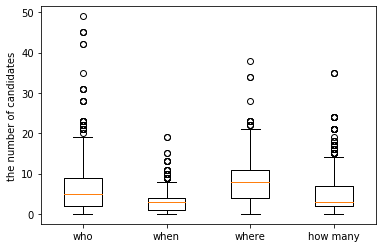

In [34]:
import matplotlib.pyplot as plt

soft_group = [soft_cnt_who, soft_cnt_when, soft_cnt_where, soft_cnt_howmany]

plt.clf()
plt.boxplot(soft_group)
ax = plt.gca() # grab the current axis
labels = ['who','when','where', 'how many']

ax.set_xticklabels(labels)
ax.set_ylabel('the number of candidates')
#ax.set_title('The number of entities which have same type with answer in document')

In [8]:
test_candy = ['who','where','when','how many']

## all

In [13]:
hard_cnt_wa = []
soft_cnt_wa = []

hard_cnt_fp = []
soft_cnt_fp = []

hard_cnt_fn = []
soft_cnt_fn = []

hard_cnt_right = []
soft_cnt_right = []

for document in tqdm_notebook(data):
    for paragraph in document['paragraphs']:
        document = paragraph['context']        
        for qas in paragraph['qas']:
            
            wh = findWHword(qas['question'])
            if wh == 'whose' or wh == 'whom': wh = 'who'
            
            if wh not in test_candy: continue
                
            if qas['id'] in wrong_bert_wa:
                if qas['id'] in possible_answers_hard:
                    hard_cnt_wa.append(possible_answers_hard[qas['id']])
                    
                if qas['id'] in possible_answers_soft:
                    soft_cnt_wa.append(possible_answers_soft[qas['id']])
                
            elif qas['id'] in wrong_bert_fp:
                if qas['id'] in possible_answers_hard:
                    hard_cnt_fp.append(possible_answers_hard[qas['id']])
                    
                if qas['id'] in possible_answers_soft:
                    soft_cnt_fp.append(possible_answers_soft[qas['id']])
                
            elif qas['id'] in wrong_bert_fn:
                if qas['id'] in possible_answers_hard:
                    hard_cnt_fn.append(possible_answers_hard[qas['id']])
                    
                if qas['id'] in possible_answers_soft:
                    soft_cnt_fn.append(possible_answers_soft[qas['id']])
                
            else:
                if qas['id'] in possible_answers_hard:
                    hard_cnt_right.append(possible_answers_hard[qas['id']])
                    
                if qas['id'] in possible_answers_soft:
                    soft_cnt_right.append(possible_answers_soft[qas['id']])

In [10]:
import matplotlib.pyplot as plt

In [11]:
hard_group = [hard_cnt_wa, hard_cnt_fn, hard_cnt_right]

Text(0, 0.5, 'the number of candidates')

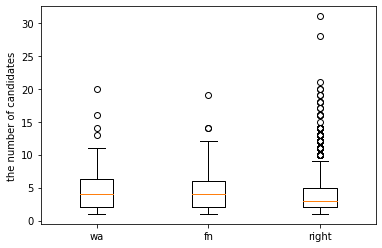

In [12]:
plt.clf()
plt.boxplot(hard_group)
ax = plt.gca() # grab the current axis
labels = ['wa','fn','right']

ax.set_xticklabels(labels)
ax.set_ylabel('the number of candidates')
#ax.set_title('The number of entities which have same type with answer in document')

Text(0, 0.5, 'the number of candidates')

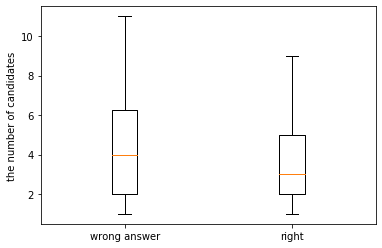

In [16]:
hard_group = [hard_cnt_wa, hard_cnt_right]

plt.clf()
plt.boxplot(hard_group, showfliers=False)
ax = plt.gca() # grab the current axis
labels = ['wrong answer','right']

ax.set_xticklabels(labels)
ax.set_ylabel('the number of candidates')
#ax.set_title('The number of entities which have same type with answer in document')

In [29]:
soft_group = [soft_cnt_wa, soft_cnt_fp, soft_cnt_fn, soft_cnt_right]

Text(0, 0.5, 'the number of candidates')

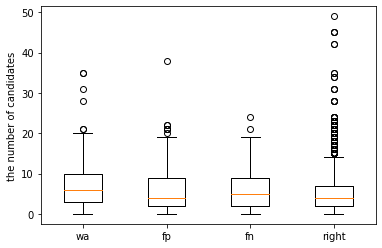

In [30]:
plt.clf()
plt.boxplot(soft_group)
ax = plt.gca() # grab the current axis
labels = ['wa','fp','fn','right']

ax.set_xticklabels(labels)
ax.set_ylabel('the number of candidates')
#ax.set_title('The number of entities which have same type with answer in document')

4

In [38]:
import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr
t, p = ttest_ind(soft_cnt_wa, soft_cnt_right, equal_var=False)

In [39]:
t,p

(3.7425498552607954, 0.0002510706067172243)